# Imports

In [2]:
import os, re, sys, pickle, datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
#from sklearn import tree

import statsmodels.api as sm
import multiprocessing
nproc = max([1,multiprocessing.cpu_count()-2])
from joblib import Parallel,delayed



import warnings
warnings.filterwarnings("ignore")

import loo_q2 as loo

randomstate = 42

def plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(6,6))
    plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker="s",facecolor='none')
    plt.scatter(y_train,y_pred_train,label="training",color="black",marker="s") # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color="#BA204E",marker=".", s=300)     #,alpha=0.25
    plt.plot(y_train,yy_fit_line,color="black") #,alpha=0.2
    if leg:
        plt.legend(loc='lower right')
    plt.xlabel(label+" measured",fontsize=20)
    plt.ylabel(label+" predicted",fontsize=20)
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav)

def r2_val(y_test,y_pred_test,y_train):
    """Calculates the external R2 pred as described:
    https://pdfs.semanticscholar.org/4eb2/5ff5a87f2fd6789c5b9954eddddfd1c59dab.pdf"""
    y_resid = y_pred_test - y_test
    SS_resid = np.sum(y_resid**2)
    y_var = y_test - np.mean(y_train)
    SS_total = np.sum(y_var**2)
    r2_validation = 1-SS_resid/SS_total
    return(r2_validation)

def repeated_k_fold(X_train,y_train,reg = LinearRegression(), k=3, n=100):
    """Reapeated k-fold cross-validation. 
    For each of n repeats, the (training)data is split into k folds. 
    For each fold, this part of the data is predicted using the rest. 
    Once this is done for all k folds, the coefficient of determination (R^2) of the predictions of all folds combined (= the complete data set) is evaluated
    This is repeated n times and all n R^2 are returned for averaging/further analysis
    """
    
    rkf = RepeatedKFold(n_splits=k, n_repeats=n)
    r2_scores = []
    y_validations,y_predictions = np.zeros((np.shape(X_train)[0],n)),np.zeros((np.shape(X_train)[0],n))
    foldcount = 0
    for i,foldsplit in enumerate(rkf.split(X_train)):
        fold, rep = i%k, int(i/k) # Which of k folds. Which of n repeats
        model = reg.fit(X_train[foldsplit[0]],y_train[foldsplit[0]]) # foldsplit[0]: k-1 training folds
        y_validations[foldcount:foldcount+len(foldsplit[1]),rep] = y_train[foldsplit[1]] # foldsplit[1]: validation fold
        y_predictions[foldcount:foldcount+len(foldsplit[1]),rep]  = model.predict(X_train[foldsplit[1]])
        foldcount += len(foldsplit[1])
        if fold+1==k:
            foldcount = 0
    r2_scores = np.asarray([metrics.r2_score(y_validations[:,rep],y_predictions[:,rep]) for rep in range(n)])
    return(r2_scores)

In [3]:
def plot_fit_label(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(5,5))
    plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker="s",facecolor='none')
    plt.scatter(y_train,y_pred_train,label="training",color="black",marker="s") # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color="#BA204E",marker=".", s=300)     #,alpha=0.25
    plt.plot(y_train,yy_fit_line,color="black") #,alpha=0.2
    
    #Create list of tuples for y pred and y all
    y_labels_test = y_labels[VS]
    for (x,y,name) in zip(list(y_test),list(y_pred_test),list(y_labels_test)):
        plt.text(x,y,name)
    
    model_df = {'y_labels'}
    
    if leg:
        plt.legend(loc='lower right')
    
    #if label_all:
    #    plt.text(y_train,y_pred_train,y_labels[TS])
    #    plt.text(y_test,y_pred_test,y_labels[VS])
    plt.xlabel(label+" measured",fontsize=20)
    plt.ylabel(label+" predicted",fontsize=20)
    plt.tight_layout()
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav)

# Reading data

## Single File

In [4]:
# all data in a single file
excel_file = "IFD_parameters"
excel_sheet = "param"
num_par = 389
par_start_col = 2 # 0-indexed
num_samples = 66
response_col = 1 # 0-indexed
y_label_col = 0 # 0-indexed

apply_mask = True # remove samples with empty response
verbose = True
xlabelrow = True

inp = pd.read_excel(excel_file+".xlsx",excel_sheet,header=0,index_col=y_label_col,nrows=num_samples+int(xlabelrow),
                    usecols=max(y_label_col,response_col,num_par+par_start_col)-1)

if xlabelrow:
    X_names = list(inp.iloc[0,par_start_col-1:num_par+par_start_col-1])
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    resp_label = list(inp.columns)[response_col-1]
    inp.drop(index=inp.index[0],inplace=True)
else:
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    X_names = X_labels
    resp_label = list(inp.columns)[response_col-1]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))
y = np.asarray(inp[resp_label],dtype=np.float)
X = np.asarray(inp[X_labels],dtype=np.float)
y_labels = np.asarray(list(inp.index),dtype=str)
y_labels_comp= y_labels

if apply_mask:
    mask = y.nonzero()[0]
    mask = ~np.isnan(y)
    print("n_samples before removing empty cells: {}".format(len(y)))
    print("Removing {} samples.".format(len(y)-sum(mask)))
    X = X[np.array(mask)]
    y = y[np.array(mask)]
    y_labels = y_labels[np.array(mask)]
X_all = X
if verbose:
    print("Shape X: {}".format(X.shape))
    print("Shape y: {}".format(y.shape)) 
    print("Shape labels: {}".format(y_labels.shape)) 
    print("First X cell: {}".format(X[0,0]))
    print("Last X cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label: {}".format(y_labels[-1]))
    #print(inp.head())

n_samples before removing empty cells: 66
Removing 0 samples.
Shape X: (66, 389)
Shape y: (66,)
Shape labels: (66,)
First X cell: 5.666249999999999
Last X cell:  0.010000000000000231
First y: -1.712
Last y:  1.0
Last label: Y343W_5


# Data preparation: Training/Test set split, Scaling

## Preselection: Exclusion

In [7]:
# remove samples based on index (0-indexed)
# comment-out first line of code in Train/test split if using this

exclude = []

#External Validation Datapoints: 52,53,54,55,56,57,58,59,60,61,62,62,63,64,65

print(exclude)
mask = [i for i in range(len(y)) if i not in exclude]
X_sel,y_sel,y_labels_sel = X[mask],y[mask],y_labels[mask]
print(y_sel)
print(y_labels_sel)

[]
[-1.712      -1.832      -1.61       -1.367      -0.413      -1.079
 -0.49569351 -0.8158611  -0.59325122 -1.40119914 -0.88280067 -1.40859595
 -0.7219804  -0.89875399 -1.37232413 -1.30462617 -1.1681862  -1.07051126
 -1.70836865 -1.06566946 -0.85934539 -1.18471636 -1.79264445 -0.77768694
 -0.95677793 -1.85998637 -0.8289009  -1.84596725 -1.08027726 -1.23644004
 -2.11633153 -1.31769366 -1.66448865 -1.1736591  -1.36527585 -0.16787329
 -0.6210859  -0.70344881 -0.26339157 -0.46592353 -0.42703422 -0.13325299
 -0.2903079  -0.32533254 -0.37554815 -0.5043021  -0.37287552 -0.17781213
 -0.66886128 -0.63049749 -0.57350153 -0.39570719  1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.        ]
['0' '4' '5' '11' '13' '21' 'W66A_0' 'W66D_0' 'W66L_0' 'W66F_0' 'Y177F_0'
 'Y177W_0' 'W66L_4' 'Y177F_4' 'Y177W_4' 'F269A_0' 'F269D_0' 'F269L_0'
 'F269W_0' 'F269A_4' 'F269D_4' 'F269L_4' 'F269W_4' 'Y343A_0' 'Y343D_0'

## Training/Test set split

TS: [1, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 27, 28, 30, 32, 33, 34, 37, 38, 39, 40, 41, 43, 44, 46, 47, 48, 49, 50]
VS: [0, 2, 11, 12, 19, 24, 25, 26, 29, 31, 35, 36, 42, 45, 51]
y_mean TS: -0.956
y_mean VS: -0.980
Shape X_train: (37, 389)
Shape X_test:  (15, 389)


<IPython.core.display.Javascript object>


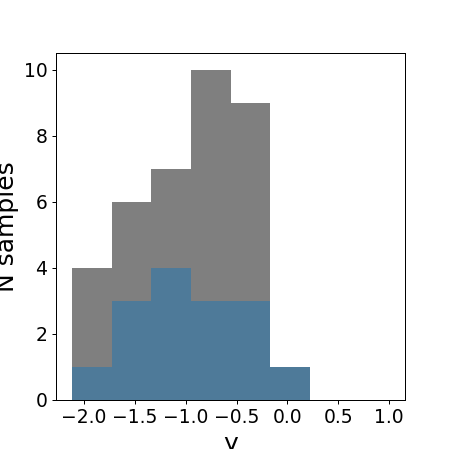

In [15]:
# comment next line out if preselection was performed in the cell above
#X_sel,y_sel,labels_sel,exclude = X,y,y_labels,[]

# select method of split:
    # y_equidist - picks points that evenly span the output variable y. 
    # define - give a list of sample indices for either VS or TS in the corresponding code section 
    
# the numbers in the variables VS and TS refer to the original 0-indexed sample numbers 

split = "define"#random"
test_ratio = 0.3

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y_sel, random_state=randomstate+3, test_size=test_ratio)    
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
    
elif split == "define":
    # numbers according to sample lines in the excel sheet (that is, including indexes of 'excluded' samples)
    #This "define" is y_eq when Validation Dataset is excluded in the cell above
    TS = [1, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 27, 28, 30, 32, 33, 34, 37, 38, 39, 40, 41, 43, 44, 46, 47, 48, 49, 50]
    VS = [0, 2, 11, 12, 19, 24, 25, 26, 29, 31, 35, 36, 42, 45, 51] 
    #VS = [52,53,54,55,56,57,58,59,60,61,62,62,63,64,65] #externalvalidation
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
elif split == "ks":
    import kennardstonealgorithm as ks
    TS,VS = ks.kennardstonealgorithm(X_sel,int((1-test_ratio)*np.shape(X_sel)[0]))
    X_train, y_train,X_test, y_test = X_sel[TS], y_sel[TS],X_sel[VS], y_sel[VS]
  
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]   

elif split == "y_eq":
    no_extrapolation = True
    
    import kennardstonealgorithm as ks
    if no_extrapolation:
        minmax = [np.argmin(y_sel),np.argmax(y_sel)]
        y_ks = np.array(([i for i in y_sel if i not in [np.min(y_sel),np.max(y_sel)]]))
        y_ks_indices = [i for i in range(len(y_sel)) if i not in minmax]
        
        # indices relative to y_ks:
        VS_,TS_ = ks.kennardstonealgorithm(y_ks.reshape(np.shape(y_ks)[0],1),int((test_ratio)*np.shape(y_ks)[0]))
        # indices relative to y_sel:
        TS_ = sorted([y_ks_indices[i] for i in list(TS_)]+minmax)
        VS_ = sorted([y_ks_indices[i] for i in VS_])
        
    else:
        VS_,TS_ = ks.kennardstonealgorithm(y_sel.reshape(np.shape(y_sel)[0],1),int((test_ratio)*np.shape(y_sel)[0]))
    
    X_train, y_train,X_test, y_test = X_sel[TS_], y_sel[TS_],X_sel[VS_], y_sel[VS_]

    # indices relative to y
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]

elif split == "none":
    TS, VS = [i for i in range(X.shape[0]) if i not in exclude],[]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
else: 
    raise ValueError("split option not recognized")
     

print("TS: {}".format(TS))
print("VS: {}".format(VS))
print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(5, 5))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
# plt.legend(loc='best')
plt.xlabel("y",fontsize=20)
plt.ylabel("N samples",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Feature Scaling 

In [12]:
# scale features 

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_all_sc = scaler.transform(X_all)

# Linear modelling, feature selection

## Manual selection of features

Features: x13 + x191 + x207 + x252 + x253 + x320 + x343

Parameters:
   -0.9562 + 
   -0.1580 * x13 100B5
   -0.1754 * x191 269B5GSS
   -0.1395 * x207 343L-S-Max-Min
    0.1257 * x252 pdt_dynam_SA_100
   -0.1962 * x253 pdt_dynam_SA_172
   -0.0851 * x320 NBO_carbonyl_O_pdt
   -0.2098 * x343 NBO_beta_H_pdt_min

Training R2  = 0.830
Training Q2  = 0.725
Training MAE = 0.175
Training K-fold R2 = 0.688 (+/- 0.002)

Test R2      = 0.569
Test MAE     = 0.289


<IPython.core.display.Javascript object>


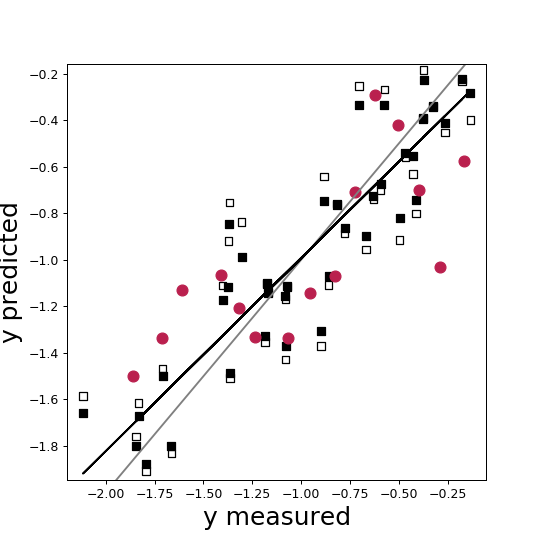

<IPython.core.display.Javascript object>


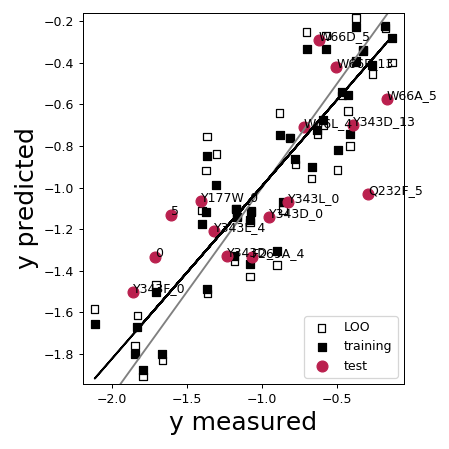

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     20.16
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           1.50e-09
Time:                        16:29:57   Log-Likelihood:                 4.1473
No. Observations:                  37   AIC:                             7.705
Df Residuals:                      29   BIC:                             20.59
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9562      0.040    -23.806      0.0

In [16]:
#use this cell for visualizing models if the Forward Stepwise has not been run 
#These Features are the features for the Selected Model 
features_x =  " x13 + x191 + x207 + x252 + x253 + x320 + x343"

features_py = sorted([X_labels.index(i.strip()) for i in features_x.split("+")])

# features_py = []
#features = sorted([int(i[1:]) for i in re.findall("x\d+",features_x)])
#features_py = [i-1 for i in features]


X_train_sel = X_train_sc[:,features_py]
X_test_sel = X_test_sc[:,features_py]
lr = LinearRegression().fit(X_train_sel, y_train)

y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores = repeated_k_fold(X_train_sel,y_train,k=4,n=200)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(features_py)[i]]) for i in range(len(features_py))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores.mean(), kfoldscores.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)
plot_fit_label(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=loo_train)

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
print(model.summary())

print("VS: {}".format(VS))
print("VS predictions:")
print (y_pred_test) 

## Forward stepwise selection keeping a set of candidates at each step

### Model search

Step 1
Step 2
Finished 1 and 2 parameter models. Time taken (sec): 31.7368
Step 3
cutpar:  1
cutpar:  1
cutpar:  1
Step 4
cutpar:  1
cutpar:  1
cutpar:  1
Step 5
cutpar:  2
cutpar:  2
cutpar:  2
Step 6
cutpar:  2
cutpar:  2
cutpar:  2
Step 7
cutpar:  2
cutpar:  2
cutpar:  2
Step 8
cutpar:  3
cutpar:  3
cutpar:  3
Step 9
cutpar:  3
cutpar:  3
cutpar:  3
Step 10
cutpar:  3
cutpar:  3
cutpar:  3
Done. Time taken (minutes): 522.13


Best model:
1 + x136 + x173 + x2 + x220 + x224 + x226 + x247 + x307 + x313 + x78
1 + 342PAGS + 342-Dist16-19-S-Max-Min + 100PAMax-Min + sub_dynam_vol_FMN + pdt_dynam_SA_FMN + pdt_dynam_SA_343 + pdt_dynam_vol_177 + NBO_beta_H_pdt_min + 66B5GS + 261D13-20Max-Min

Features: x2 + x78 + x136 + x173 + x220 + x224 + x226 + x247 + x307 + x313

Parameters:
   -0.9562 + 
   -0.1761 * x2 66LGS
    0.1909 * x78 261B5GS
   -0.1225 * x136 100PA-S
   -0.0925 * x173 232B5GSS
    0.2642 * x220 66DSprod-sub(MAX)
    0.0980 * x224 sub_dynam_SA_FMN
   -0.2338 * x226 sub_dynam_SA_1

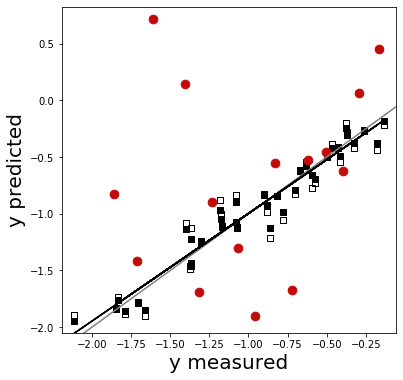

In [7]:
# Forward stepwise selection keeping a set of candidates at each step
n_steps = 10
n_candidates = 200
collin_criteria = 0.4 # this is R2
skipfeatures = [] #["x4","x3"]

import ForwardStepCandidates_2 as fsc
df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))
newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
df.drop(skipfeatures,axis=1,inplace=True)

results,models,scores,sortedmodels,candidates = fsc.ForwardStep_py(df,'y',
                    n_steps=n_steps,n_candidates=n_candidates,collin_criteria=collin_criteria)
model_sel = results.loc[0,"Model"]
selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
print("\n\nBest model:")
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[candidates[0]].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)

#Add sorting to results DF - second revision will alter the ForwardStepCandidates_2b itself to include options
#prioritize validation R2 over Q2 + include K-fold

scores_r2_test = []
k_fold = []

for model in sortedmodels:
    X_sel = list(model)
    X_sel_i = [X_labels.index(i.strip()) for i in X_sel]
    X_train_sel = X_train_sc[:,X_sel_i]
    X_test_sel = X_test_sc[:,X_sel_i]
    lr = LinearRegression().fit(X_train_sel,y_train)
    #kfoldscores = cross_val_score(lr,X_train_sel,y_train,cv=RepeatedKFold(n_splits=4, n_repeats=50))
    #k_fold.append(kfoldscores)
    y_pred_train = lr.predict(X_train_sel)
    y_pred_test = lr.predict(X_test_sel)
    model_test_r2_score = r2_val(y_test,y_pred_test,y_train)
    scores_r2_test.append(model_test_r2_score)
        
test_r2_df = pd.DataFrame(scores_r2_test, columns=['Test R^2'])
#k_fold_df = pd.DataFrame(k_fold,columns=['K Fold'])
#results = pd.concat([results,test_r2_df,k_fold_df])
results = pd.concat([results,test_r2_df],axis=1)

# selected_feats = [x_labels.index(i) for i in models[candidates[0]].terms]
# X_train_sel = X_train_sc[:,selected_feats]
# X_test_sel = X_test_sc[:,selected_feats]
# y_pred_train = models[candidates[0]].model.predict(X_train_sel)
# y_pred_test =  models[candidates[0]].model.predict(X_test_sel)
# print("\nBest model:")
# print(models[candidates[0]].formula)
# print("1 + "+" + ".join([x_names[x_labels.index(i)] for i in models[candidates[0]].terms])+"\n")
# print("R^2 = {:.2f}".format(models[candidates[0]].r2))
# print("Q^2 = {:.2f}".format(models[candidates[0]].q2))
# print("R^2_test = {:.2f}".format(models[candidates[0]].model.score(X_test_sel, y_test)))
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
# models[candidates[0]].r2,models[candidates[0]].q2,metrics.r2_score(y_pred_test,y_test)))

# plot_fit(y_train,y_pred_train,y_test,y_pred_test)


### Well-Validated Models

In [12]:
#View only well validated models (criteria = test R2 must be within 0.3 of training R2, Q2 within 0.1 of training R2)
results['diff_R2'] = results['R^2']-results['Test R^2']
results['diff_Q2'] = results['R^2']-results['Q^2']

validatedmodels = results[results.diff_R2<0.15][results.diff_Q2<0.15].sort_values(by=['diff_R2','diff_Q2'],ascending=True)

#Evaluate k-fold of these well validated models 

kfold = []

for model in validatedmodels['Model'].tolist():
    params_used = [X_labels.index(i) for i in models[model].terms]
    X_train_sel = X_train_sc[:,params_used]
    X_test_sel = X_test_sc[:,params_used]
    lr = LinearRegression().fit(X_train_sel, y_train)
    kfoldscores = repeated_k_fold(X_train_sel,y_train,k=4,n=200)
    kfold_avg = np.mean(kfoldscores)
    kfold.append(kfold_avg)
    
kfold_df = pd.DataFrame(kfold,columns=['K Fold'],index=validatedmodels.index.values)
validatedmodels_kfold = pd.concat([validatedmodels,kfold_df],axis=1)

#Save CSV - can modify number of exported models in .head(XXX)
validatedmodels_kfold.to_csv(excel_file + '_' + excel_sheet + '_modelssorted.csv')
validatedmodels_kfold.sort_values(by=['K Fold'],ascending=False).head(25)

,Model,n_terms,R^2,Q^2,Test R^2,diff_R2,diff_Q2,K Fold
68687,"(x207, x340, x50, x6)",4,0.654368,0.547424,0.514409,0.139959,0.106944,0.526525
70510,"(x207, x312, x355, x49)",4,0.659024,0.534091,0.511426,0.147598,0.124932,0.512752
72408,"(x125, x207, x340)",3,0.603368,0.519201,0.455497,0.147871,0.084167,0.500397
72162,"(x207, x340, x6)",3,0.604222,0.521276,0.455220,0.149002,0.082947,0.499927
72447,"(x124, x207, x340)",3,0.603135,0.518862,0.458868,0.144267,0.084273,0.495724
73705,"(x210, x326, x49, x6)",4,0.602304,0.507909,0.505696,0.096609,0.094395,0.484264
74829,"(x125, x232, x341, x49)",4,0.611643,0.499087,0.463362,0.148281,0.112556,0.481829
75520,"(x207, x314, x50)",3,0.598609,0.493096,0.482729,0.115880,0.105513,0.480525
75327,"(x207, x314, x49)",3,0.600187,0.494957,0.500484,0.099703,0.105230,0.478183
75326,"(x207, x312, x49)",3,0.600187,0.494957,0.500484,0.099703,0.105230,0.476475


### View models as list

In [10]:
# view best models as sorted by 'Test R2', 'Q^2', or 'R^2'

results.sort_values(by=['Test R^2'],ascending=False).head(25)

,Model,n_terms,R^2,Q^2,Test R^2,diff_R2,diff_Q2
60327,"(x115, x147, x154, x226, x299, x310, x331, x5)",8,0.771581,0.596270,0.580174,0.191407,0.175312
36369,"(x13, x191, x207, x252, x253, x320, x343)",7,0.829510,0.724928,0.569035,0.260475,0.104582
63368,"(x115, x184, x188, x191, x204, x235, x310, x317)",8,0.773977,0.579097,0.567228,0.206749,0.194880
61364,"(x115, x125, x226, x232, x341, x49)",6,0.746716,0.590681,0.566078,0.180637,0.156035
63763,"(x115, x147, x154, x226, x310, x331, x5)",7,0.757843,0.577006,0.557829,0.200013,0.180836
55230,"(x115, x125, x154, x226, x232, x341, x49)",7,0.782273,0.625516,0.556120,0.226153,0.156758
83611,"(x125, x207, x311)",3,0.502567,0.396228,0.552275,-0.049708,0.106339
92480,"(x113, x238, x314, x367)",4,0.440473,0.241840,0.544897,-0.104424,0.198633
74950,"(x207, x342, x83, x87)",4,0.616189,0.498107,0.544382,0.071807,0.118082
75823,"(x207, x340, x49)",3,0.595061,0.490177,0.539827,0.055234,0.104884


### Visualize models

In [40]:
# selected model is 36369
model_sel = results.loc[36369,"Model"]

#other ways of selecting models:
# model_sel = results.iloc[selmods.index[3],0]
# model_sel = results.iloc[785,0]
# model_sel = ("x100","x31")


selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)
plot_fit_label(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=loo_train)
#plot_gsk_poster(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=True,label="% Yield",loo_pred=[])

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
print(model.summary())

print("VS: {}".format(VS))
print("VS predictions:")
print (y_pred_test) 

NameError: name 'results' is not defined